In [ ]:
# Initialize Otter
import otter

<!-- BEGIN QUESTION -->

## Imports

In [29]:
import os
import sys
import string
from collections import deque
from hashlib import sha1

import numpy as np
import pandas as pd
import shap 
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_percentage_error


from sklearn.inspection import permutation_importance

<!-- BEGIN QUESTION -->

## 1. Prediction problem
[dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) of New York City Airbnb listings from 2019.
`reviews_per_month`,  acts as a proxy for the popularity of the listing. 

In [30]:
bnb_df = pd.read_csv('data/AB_NYC_2019.csv')
bnb_df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


I chose this dataframe over the other because I find the unique columns more interesting to run through and the variety of types in each column allowing for a more interesting process running through pipelines. I think it will be interested to do some quick analysis on the words under the name and see if I can do a map for the neighbourhood group too

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2. Data splitting


In [31]:
train_df, test_df = train_test_split(
    bnb_df, test_size=0.3, random_state=123
)

train_df["reviews_per_month"] = train_df["reviews_per_month"].replace(np.nan, 0)
test_df["reviews_per_month"] = test_df["reviews_per_month"].replace(np.nan, 0)

X_train, y_train = train_df.drop(columns=["reviews_per_month"]), train_df["reviews_per_month"]
X_test, y_test = test_df.drop(columns=["reviews_per_month"]), test_df["reviews_per_month"]


train_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
36150,28736148,Cozy 1 Bedroom Apt in Hamilton Heights,43431867,Tommy,Manhattan,Washington Heights,40.83256,-73.94440,Entire home/apt,96,4,0,NaN,0.00,1,17
45223,34613254,Amazing One Bedroom at the Time Square Area/72B,48146336,Irina,Manhattan,Hell's Kitchen,40.76134,-73.99299,Entire home/apt,150,30,0,NaN,0.00,20,332
14316,11144496,"New Spacious Master, Williamsburg",48819868,Nick,Brooklyn,Williamsburg,40.71119,-73.95097,Private room,200,1,0,NaN,0.00,1,0
1691,766814,Adorable Midtown West Studio!,4022922,Caitlin,Manhattan,Hell's Kitchen,40.75900,-73.99530,Entire home/apt,95,1,0,NaN,0.00,1,0
20195,16162621,NEW! Exceptional 2BR/1BA Williamsburg Oasis,104781467,Russell,Brooklyn,Williamsburg,40.71306,-73.94856,Entire home/apt,199,3,1,2016-12-11,0.03,1,0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 3. EDA


Target value is the reviews per month aka a numerical and continuous value therefore a regression problem.

In [32]:
train_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.422600e+04,3.422600e+04,34226.000000,34226.000000,34226.000000,34226.000000,34226.000000,34226.000000,34226.000000,34226.000000
mean,1.893979e+07,6.726273e+07,40.729142,-73.952083,151.528399,7.094957,23.244814,1.090058,7.042453,112.526004
std,1.101332e+07,7.840511e+07,0.054531,0.046201,236.628392,21.548290,44.573323,1.614532,32.590803,131.420031
min,2.539000e+03,2.438000e+03,40.506410,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.394482e+06,7.721897e+06,40.690193,-73.983030,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.954546e+07,3.074526e+07,40.723240,-73.955550,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915085e+07,1.068375e+08,40.763287,-73.936270,175.000000,5.000000,23.000000,1.570000,2.000000,225.750000
max,3.648561e+07,2.743213e+08,40.912340,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Of the numerical values the ones with the largest range in values appears to be the price.

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34226 entries, 36150 to 15725
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              34226 non-null  int64  
 1   name                            34216 non-null  object 
 2   host_id                         34226 non-null  int64  
 3   host_name                       34209 non-null  object 
 4   neighbourhood_group             34226 non-null  object 
 5   neighbourhood                   34226 non-null  object 
 6   latitude                        34226 non-null  float64
 7   longitude                       34226 non-null  float64
 8   room_type                       34226 non-null  object 
 9   price                           34226 non-null  int64  
 10  minimum_nights                  34226 non-null  int64  
 11  number_of_reviews               34226 non-null  int64  
 12  last_review                     2

There are 16 columns with 14669 rows and null values in some names, hostnames and last reviews

In [34]:
X_train['neighbourhood_group'].value_counts()

neighbourhood_group
Manhattan        15176
Brooklyn         14050
Queens            3974
Bronx              771
Staten Island      255
Name: count, dtype: int64

The most popular neighbourhood is Manhattena nd Brooklyn with the others being significantly smaller

In [35]:
train_df.shape

(34226, 16)

16 columns and 14669 rows confirmed.

Text(0.5, 1.0, 'Map of Airbnb Areas')

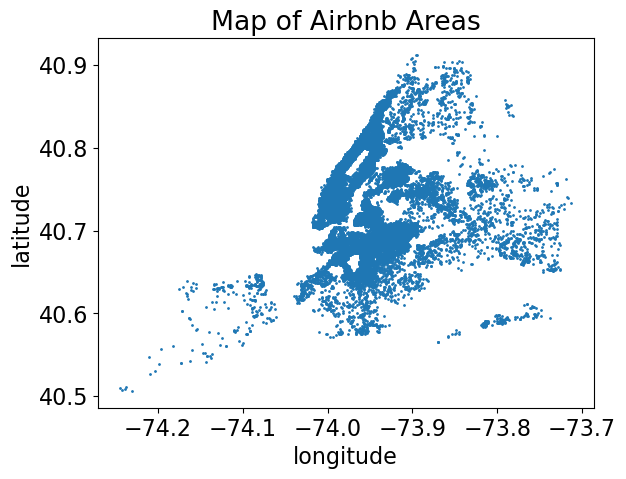

In [36]:
plt.plot(X_train["longitude"], X_train["latitude"], ".", markersize=2)
plt.xlabel("longitude")
plt.ylabel("latitude");
plt.title("Map of Airbnb Areas")

The listings are centered around longitutde -74

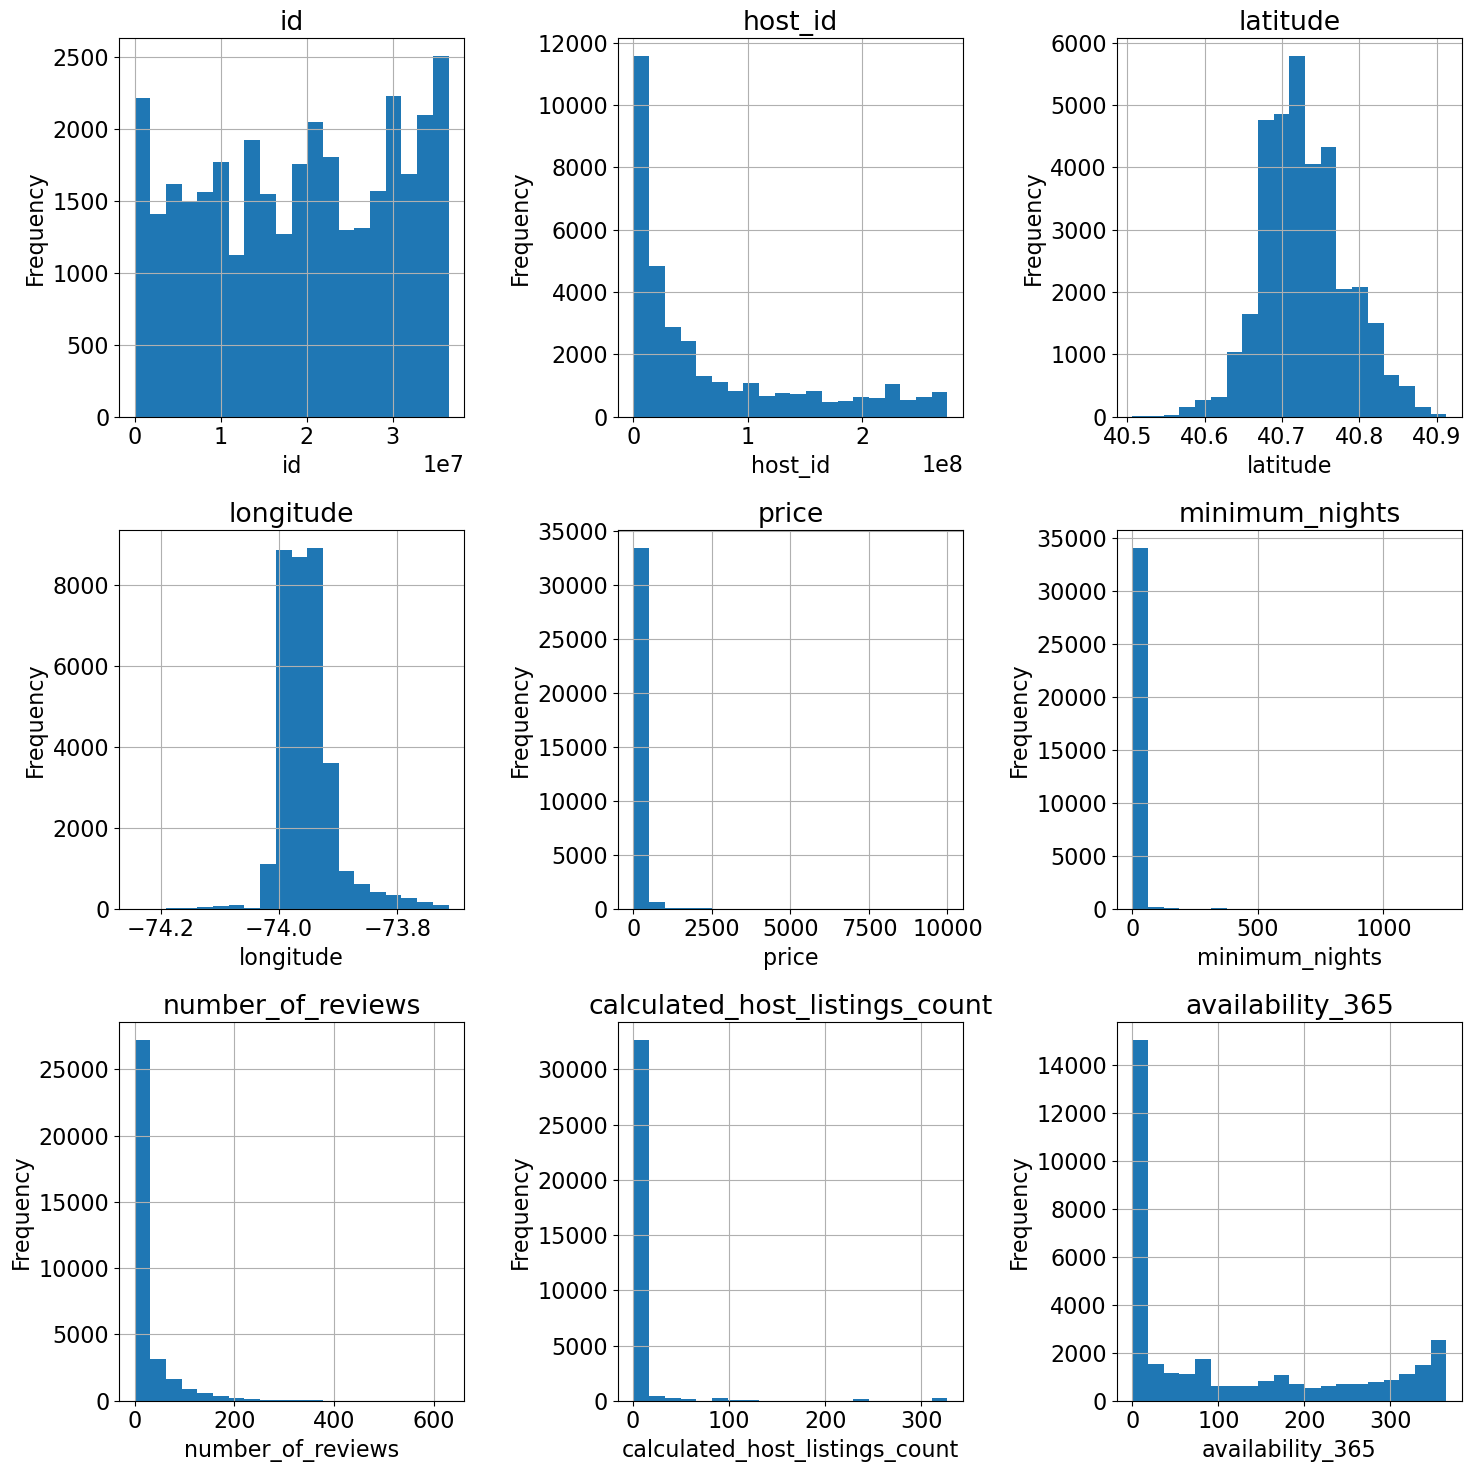

In [37]:
X_train.hist(bins=20, figsize=(15, 15));


#asked chatgpt for help labeling
for ax, col in zip(plt.gcf().axes, X_train.columns):
    ax.set_xlabel(ax.get_title())
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

- ID and hostID are not useful
- the longitude and latitude confirm the high number of listings in central New York
- Most have an under $2000 price
- For the vast majority of listings there is a short minimum stay
- There are usually 0 reviews
- Hosts usually only own one listing
- Availibiltiy is usually low out of the 365 days

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 4. Preprocessing and transformations


In [39]:
numeric_feats = [
    "latitude",
    "longitude",
    "price",
    "minimum_nights",
    "number_of_reviews",
    "calculated_host_listings_count",
    "availability_365",
]  # apply scaling
categorical_feats = [
    "neighbourhood_group",
    "neighbourhood",
]  # apply one-hot encoding
ordinal_feats = ["room_type"]  # apply ordinal encoding
text_feat = ["name", "host_name"] #apply count vectorizer
drop_feats = [
    "id",
    "host_id",
    "last_review"]  
# do not include these features


room_types = ['Shared room', 'Private room', 'Entire home/apt']
assert set(room_types) == set(X_train["room_type"].unique())

In [40]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(handle_unknown='ignore'), categorical_feats),
    (OrdinalEncoder(categories=[room_types], dtype=int), ordinal_feats),
    ("drop", drop_feats),
    (make_pipeline(
        FunctionTransformer(lambda X: pd.Series(X.flatten() if hasattr(X, 'flatten') else X).fillna('').astype(str).to_numpy(),             feature_names_out='one-to-one'  # Added this parameter
), #claude assist after debugging
        CountVectorizer(max_features=100, min_df=1)
    ), "name"))

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 5. Baseline model


In [18]:
dummy = DummyRegressor()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.016480,0.000618,-1.523816e-07,0.0
1,0.017634,0.000691,-2.849656e-05,0.0
2,0.002100,0.000489,-9.792679e-06,0.0
3,0.006426,0.000380,-1.432473e-05,0.0
4,0.002299,0.000483,-1.677089e-04,0.0


In [20]:
scores['test_score'].mean()

np.float64(-4.4095040527558635e-05)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Linear models 


In [15]:
pipeRidge = make_pipeline(preprocessor, Ridge())
pipeRidge.fit(X_train, y_train)


,steps,"[('columntransformer', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standardscaler', ...), ('onehotencoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


{'ridge__alpha': np.float64(10.0)}

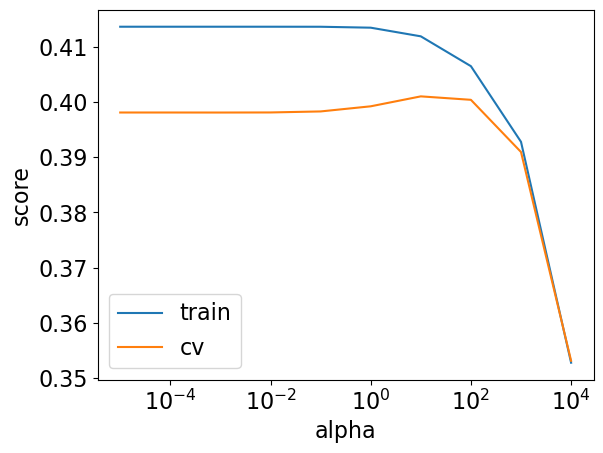

In [16]:
#adapted from Lecture 10
param_grid = {"ridge__alpha": 10.0 ** np.arange(-5, 5, 1)}

pipe_ridge = make_pipeline(preprocessor, Ridge())

search = GridSearchCV(pipe_ridge, param_grid, return_train_score=True, n_jobs=-1)
search.fit(X_train, y_train)
train_scores = search.cv_results_["mean_train_score"]
cv_scores = search.cv_results_["mean_test_score"]

plt.semilogx(param_grid["ridge__alpha"], train_scores.tolist(), label="train")
plt.semilogx(param_grid["ridge__alpha"], cv_scores.tolist(), label="cv")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("score");

best_alpha = search.best_params_
best_alpha

In [39]:
alphas = 10.0 ** np.arange(-6, 6, 1)
ridgecv_pipe = make_pipeline(preprocessor, RidgeCV(alphas=alphas, cv=10))
ridgecv_pipe.fit(X_train, y_train);

In [18]:
scores1 = cross_validate(pipe_ridge, X_train, y_train, return_train_score=True)
scores2 = cross_validate(ridgecv_pipe, X_train, y_train, return_train_score=True)
a = pd.DataFrame(scores2)
b = pd.DataFrame(scores1)

print(a)
print(b)

    fit_time  score_time  test_score  train_score
0  11.562120    0.034838    0.415030     0.402355
1  11.119226    0.035648    0.406038     0.404489
2  11.193240    0.034456    0.342539     0.428176
3  11.245339    0.035598    0.422096     0.406393
4  11.801585    0.035704    0.415750     0.407946
   fit_time  score_time  test_score  train_score
0  0.378765    0.035265    0.415321     0.408978
1  0.261043    0.035449    0.406727     0.411091
2  0.268987    0.034393    0.340965     0.429713
3  0.265782    0.035284    0.419536     0.408046
4  0.270585    0.035124    0.413608     0.409570


With medium complexity at alpha =  10 we find the best train and test score ratio. While there is underfitting with the low score, according to the graph this will not change with even the training score maxing at around 41%. What we can analyze in more depth in this scenario is how to prevent overfitting. The best point here is the alpha mentioned above

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 7. Different models


K Nearest Neighbours

In [34]:
knn_pipe = make_pipeline(preprocessor, KNeighborsRegressor())

In [35]:
scores3 = cross_validate(knn_pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores3)

,fit_time,score_time,test_score,train_score
0,0.156354,6.463038,0.372270,0.567431
1,0.154939,6.507168,0.353077,0.570858
2,0.147801,6.424334,0.323580,0.578006
3,0.146414,6.321738,0.371059,0.577173
4,0.145865,6.137236,0.340736,0.571974


Random Forest

In [14]:
pipe_rf = make_pipeline(preprocessor, RandomForestRegressor(n_jobs=-1, random_state=123))

In [51]:
scores4 = cross_validate(pipe_rf, X_train, y_train, return_train_score=True)
pd.DataFrame(scores4)

,fit_time,score_time,test_score,train_score
0,26.178528,0.063621,0.626507,0.945104
1,26.023379,0.074815,0.634367,0.943288
2,26.200545,0.071593,0.568980,0.945814
3,26.159455,0.076651,0.610372,0.943754
4,25.997011,0.075249,0.602998,0.944932


Support Vector Machines 

In [41]:
svm_pipe = make_pipeline(preprocessor, SVR())

In [44]:
#took too long
#scores5 = cross_validate(svm_pipe, X_train, y_train, return_train_score=True, cv=3) 
svm_pipe.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('svr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standardscaler', ...), ('onehotencoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
svm_pipe.score(X_train, y_train)

0.5169726868329094

1. K Nearest Neighbours - Near identical test score but slightly higher train store therefore higher underfitting and overfitting with an adequately fast fit/score times. Compared to the linear model there is marginal improvement only
2. Random Forest - Significantly higher train score and moderately higher test score but it's still just barely above a 50/50 shot however it is an improvement upon the linear model. The overfitting is more signifcant but it is no longer underfitting. Horrendous fit times and decent score times.
3. Support Vector Machines - Takes so long that I reran it and I couldn't have it show up again so instead I will just recall what happened, it was nearly the same as K-NN exactly and so have the same linear model near same results but a terribly slow fit time so much so that it's not worth using at all.



<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 8. Feature selection 


<div class="alert alert-warning">
    
Solution_9
    
</div>

_Points:_ 2

In [14]:
#adapted from lecture 13
rfe_pipe = make_pipeline(
    preprocessor,
    RFECV(Ridge()),
    RandomForestRegressor(n_jobs=-1, random_state=123),
)

In [ ]:
#cross validate took forever
#pd.DataFrame(cross_validate(rfe_pipe, X_train, y_train, return_train_score=True)).mean()

In [ ]:
rfe_pipe.fit(X_train, y_train)


Skipped using this as the fit time took even longer making it incredibly unviable.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 9. Hyperparameter optimization


K-NN

In [ ]:
param_grid = {
    'kneighborsregressor__n_neighbors': [3, 5, 7, 9, 11, 15, 20, 25, 30] #asked claude 
}

knn_pipe = make_pipeline(preprocessor, KNeighborsRegressor())

knn_search = GridSearchCV(knn_pipe, param_grid, return_train_score=True, n_jobs=-1)
knn_search.fit(X_train, y_train)

In [ ]:
#Forgot this reminded by claude
print(f"Best k: {knn_search.best_params_}")
print(f"Best CV score: {knn_search.best_score_:.4f}")

In [ ]:
best_knn_pipe = knn_search.best_estimator_ 
scores6 = cross_validate(best_knn_pipe, X_train, y_train, return_train_score=True)


Random Forest

In [ ]:
param_grid = {
    'randomforestregressor__n_estimators': [50, 100, 200],
    'randomforestregressor__max_depth': [10, 20, 30, None],
    'randomforestregressor__min_samples_split': [2, 5, 10]
} #asked claude for why it didn't work again name issue

pipe_rf = make_pipeline(preprocessor, RandomForestRegressor(n_jobs=-1, random_state=123))

rf_search = GridSearchCV(pipe_rf, param_grid, return_train_score=True, n_jobs=-1)
rf_search.fit(X_train, y_train)

In [ ]:
print(f"Best parameters: {rf_search.best_params_}")
print(f"Best score: {rf_search.best_score_:.4f}")

In [ ]:
best_rf_pipe = rf_search.best_estimator_ 
scores7 = cross_validate(best_rf_pipe, X_train, y_train, return_train_score=True)


SVM

In [ ]:
param_grid = {
    'svr__C': [0.1, 1, 10, 100]  
}  #asked claude for why it didn't work again name issue

svm_pipe = make_pipeline(preprocessor, SVR())

svm_search = GridSearchCV(svm_pipe, param_grid, cv=5, return_train_score=True, n_jobs=-1)
svm_search.fit(X_train, y_train)

In [ ]:
print(f"Best parameters: {svm_search.best_params_}")
print(f"Best CV score: {svm_search.best_score_:.4f}")

In [ ]:
best_svm_pipe = svm_search.best_estimator_ 
scores8 = cross_validate(best_svm_pipe, X_train, y_train, return_train_score=True)


Again took forever to run and so I cannot rerun it on my laptop to show up but the scores after optimization for the first two were only marginally better and so will not be used. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 10. Interpretation and feature importances


Tried using Random Forest and adapted from Lecture 12

In [19]:
pipe_rf.fit(X_train, y_train)

X_train_enc = preprocessor.transform(X_train).todense()
X_test_enc = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()

X_train_enc_df = pd.DataFrame(
    X_train_enc.toarray() if hasattr(X_train_enc, 'toarray') else X_train_enc,
    columns=feature_names,
    index=X_train.index
)
X_test_enc_df = pd.DataFrame(
    X_test_enc.toarray() if hasattr(X_test_enc, 'toarray') else X_test_enc,
    columns=feature_names,
    index=X_test.index
)

In [51]:
corr_df[corr_df == 1] = 0 # Set the diagonal to 0. 
high_corr = [column for column in corr_df.columns if any(corr_df[column] > 0.80)]
print(high_corr)

['pipeline__heart', 'pipeline__of']


In [52]:
corr_df['pipeline__heart']['pipeline__of'] #assumed to be part of 'heart of new york' 

np.float64(0.8163003591494035)

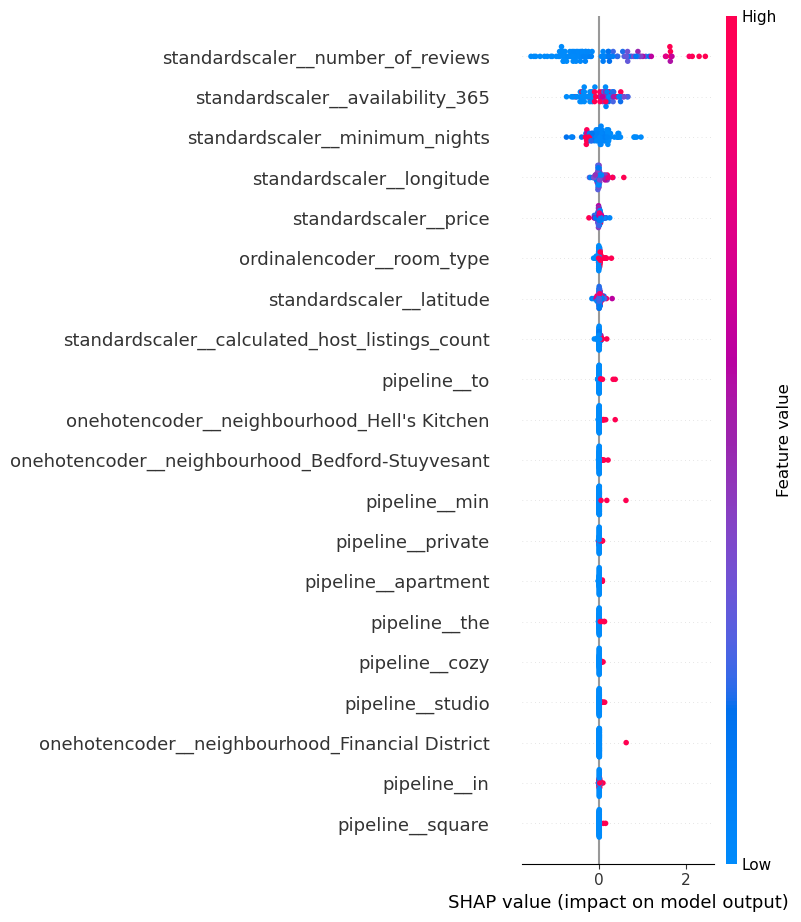

In [21]:
rf_model = pipe_rf.named_steps['randomforestregressor']
explainer = shap.TreeExplainer(rf_model)

#sample added from recommendations by claude after my laptop kept crashing
train_shap_values = explainer(X_train_enc_df.sample(100, random_state=123))
shap.summary_plot(train_shap_values, X_train_enc_df.sample(100, random_state=123))

In [22]:
shap.initjs()

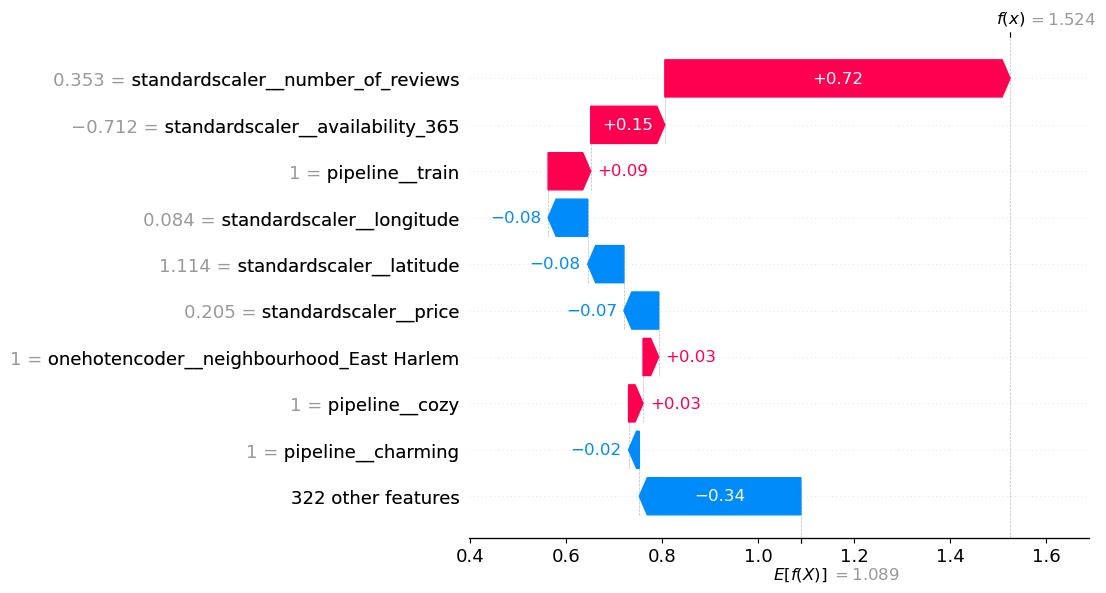

In [24]:
shap.plots.waterfall(train_shap_values[10])

Based on the data above I understand that the most involved column is the number of reviews. Some may say this sways the data as it correlates to the monthly reviews however, it's more of a statement showing us that more guests prefer locations that have been prevetted by other guests on airBNB. To remove this data point would mean losing out on this key idea. Looking at the other datapoints, more availability increases potential guests, the more northwest the more less likely guests arrive, unsurprisingly the higher the price, the fewer guests. The closer to East Harlem the more likely they review and guests prefer cozy over charming.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Results on the test set

In [19]:
pipe_rf.fit(X_train, y_train)
test_score = pipe_rf.score(X_test, y_test)

In [20]:
print(test_score)

0.6173064810440797


The best performing model was random forest as it had the highest train and validation score. Compared to the test score shown it is good at generalizing as the result is similar to what was shown by the CV analysis

In [38]:
mape = mean_absolute_percentage_error(y_test, pipe_rf.predict(X_test))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("MAPE:", mape)
print("MAE:", mae)
print("MSE:", mse)


MAPE: 0.9879585035321566
MAE: 0.5343828413661463
MSE: 0.9269022755927465


However the errors are high, the test score is already low and so it makes sense that these results are not the best

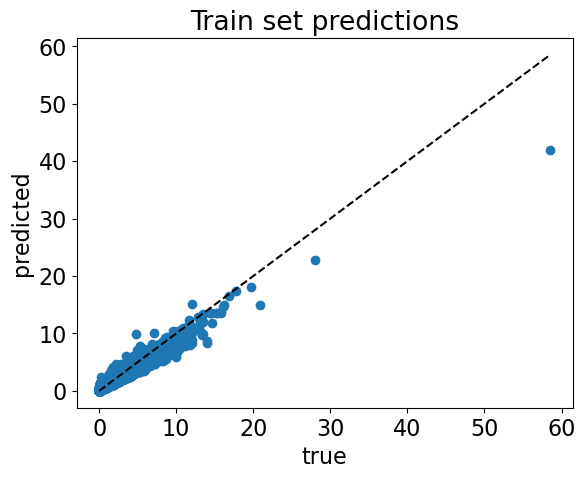

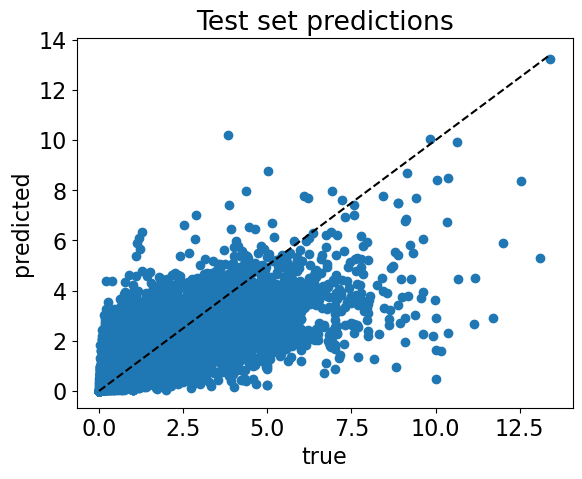

In [49]:
plt.scatter(y_train, pipe_rf.predict(X_train))
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("true")
plt.ylabel("predicted")
plt.title("Train set predictions")
plt.show()


plt.scatter(y_test, pipe_rf.predict(X_test))
grid = np.linspace(y_test.min(), y_test.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("true")
plt.ylabel("predicted")
plt.title("Test set predictions")
plt.show()


In [104]:
pd.DataFrame(scores4)

,fit_time,score_time,test_score,train_score
0,26.178528,0.063621,0.626507,0.945104
1,26.023379,0.074815,0.634367,0.943288
2,26.200545,0.071593,0.568980,0.945814
3,26.159455,0.076651,0.610372,0.943754
4,25.997011,0.075249,0.602998,0.944932


As the scores previously shown from scores4, the train data the test score is a similar value but there is some large gaps between the test and train suggesting overfitting.

In [74]:
print(X_test.iloc[1386])
print('average_monthly_reviews: ',y_test.iloc[1386])

id                                                                   27924639
name                              NYC Private home-1 bedroom/Private Entrance
host_id                                                              11305944
host_name                                                             Yahaira
neighbourhood_group                                                     Bronx
neighbourhood                                                  Williamsbridge
latitude                                                             40.87135
longitude                                                           -73.85736
room_type                                                     Entire home/apt
price                                                                     145
minimum_nights                                                              2
number_of_reviews                                                           5
last_review                                                     

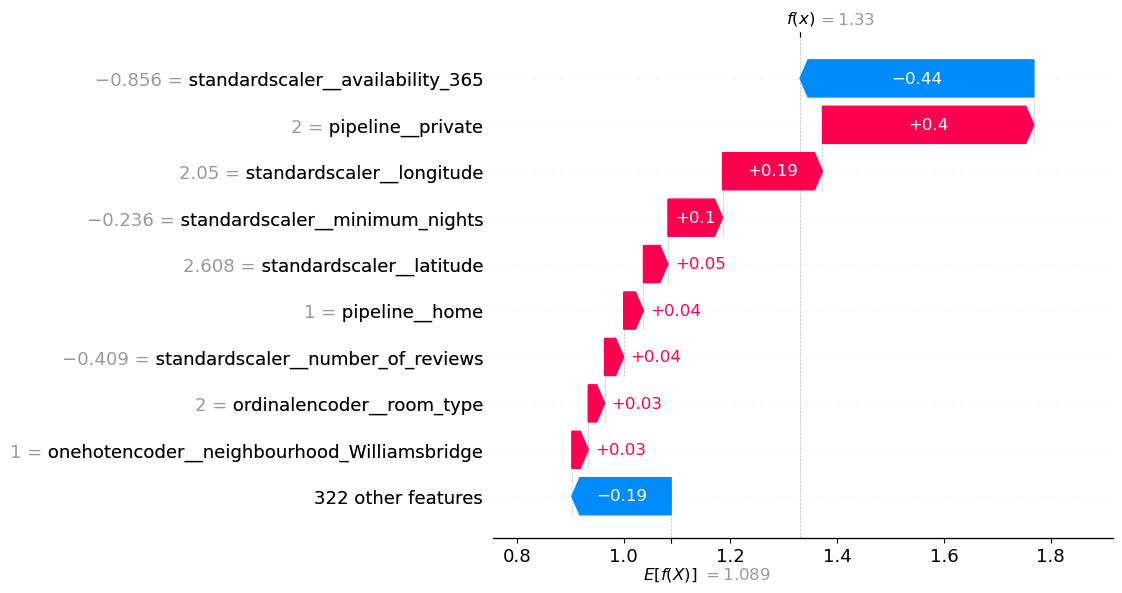

In [117]:
example = preprocessor.transform(X_test.iloc[[1386]]) #chatgpt explained the need for double brackets
explainer = shap.TreeExplainer(pipe_rf.named_steps['randomforestregressor'])

#chatgpt debugging sparse to dense
if hasattr(example, "toarray"):
    example_dense = example.toarray()
else:
    example_dense = example

#chatgpt help with labeling properlly
feature_names = preprocessor.get_feature_names_out()
example_df = pd.DataFrame(example_dense, columns=feature_names)

example_shap_values = explainer(example_df)
shap.plots.waterfall(example_shap_values[0])



The randomly selected item showed a very different reason for how they got their total estimation. High availability makes it less likely to be visited and this is assumed to be a result from overfitting and the model not being general enough. The longitude and latitude also have alternative statitistics and overall it seems quite different from the data shown previously.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 13. Summary of results


In [27]:
comparison = {
#    'dummy': [scores['train_score'].mean(), scores['test_score'].mean()],
#was so slow was faster to just manually calculate
    'dummy': [0.0, -0.000044, 'terrible scores did not do anything involving the train score and is a baseline of 0'],
    'linear_model': [0.40987, 0.40069, 'adequate improvement for a straight line run, much better than the dummy model and there was only underfitting not worried about lack of generalization as the score was near identical between test and train'],   # example placeholder
    'knn': [0.5727, 0.3529, 'marginally improved training compared to the linear model but worse test scores showing over generalization'],
    'random tree': [0.94496, 0.60864, 'significantly improved upon the training but there is significant overfitting as the it generalizes poorly but is still much better than the previous practices']    # example placeholder
}

row_labels = ['train_score', 'test_score', 'key observation']
pd.set_option('display.max_colwidth', 6000)


pd.DataFrame(comparison, index=row_labels)

,dummy,linear_model,knn,random tree
train_score,0.0,0.40987,0.5727,0.94496
test_score,-0.000044,0.40069,0.3529,0.60864
key observation,terrible scores did not do anything involving the train score and is a baseline of 0,"adequate improvement for a straight line run, much better than the dummy model and there was only underfitting not worried about lack of generalization as the score was near identical between test and train",marginally improved training compared to the linear model but worse test scores showing over generalization,significantly improved upon the training but there is significant overfitting as the it generalizes poorly but is still much better than the previous practices


More complex models we learned later in the course was much more successful than the other options mentioned. Additionally there was a significant sign of overfitting with random tree and even though I really wanted to fix it, the testing for the potential hyperparameters took too long and often crashed my device. With better RAM it would be possible to reduce the complexity to improve the test scores. I do think that my preprocessing was done very well as the training appeared to have decent improvements when comparing the different models especially after scaling. 

Propose future improvements: Discuss ideas or approaches you did not try but that could potentially improve performance or interpretability.

In the future with better resources trying different gamma and C values for Random Tree would have high potential of getting better scores and values compared to what is show now. 

Final Results: 

Test Score: 0.6173064810440797

MAPE: 0.9879585035321566

MAE: 0.5343828413661463

MSE: 0.9269022755927465

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

## 14. Takeaway


My biggest takeaway that was positive was how cool it is that the little changes we make involving how much different values matter affect our final product. When comparing the features and seeing that specific words -> 'heart' + 'of', although did not hold its original context, still had a lot of meaning that you could extract from analyzing the post preprocessing product. I enjoyed the quick responses I was able to get from small changes and it was overall very fun.

What I disliked was how slow it ended up being. I believe my preprocessing should have cut more things or switched out some of my methods for what to include as a feature since I couldn't even run some of the cell blocks taking over 30 minutes for some. I wish my laptop or my own foresight was better so that this would not have occured.

![](img/eva-well-done.png)